In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


from helpers import *
from gaussfit import *

# Create timeserie for just one pmt

def pol(x,a, b):
    return a + x*b


def decay(x, a, b, tau):
    #return a*np.exp( -x/tau )
    return a/(1-np.exp( -(x-b)/tau ))

def pmt_gain_timeserie( df, pmt, targets=[ "q", "eq"] ):

    SEL_PMT=df.pmt==pmt
    
    tmin = np.min(df[SEL_PMT].index)
    elapsedTime = [ (t-tmin) / (3600*24) for t in df[SEL_PMT].index ] #in days
    q = df[SEL_PMT][targets[0]]
    eq = df[SEL_PMT][targets[1]]
    
        
    if len(q) == 0: 
        return elapsedTime, q, eq,  [-99, -99], [-99, 99] 
    
    params,pcov = curve_fit(pol, elapsedTime , q, sigma=eq , p0=[ 0.75, -0.08 ] )
    
    return elapsedTime, q, eq, params, np.diag(pcov)**0.5


def pmt_gain_timeserie_decay( df, pmt, targets=[ "q", "eq"] ):

    SEL_PMT=df.pmt==pmt
    
    tmin = np.min(df[SEL_PMT].index)
    elapsedTime = [ (t-tmin) / (3600*24) for t in df[SEL_PMT].index ] #in days
    q = df[SEL_PMT][targets[0]]
    eq = df[SEL_PMT][targets[1]]
        
    if len(q) == 0: 
        return elapsedTime, q, eq,  [-99, -99, -99], [-99, -99, -99] 
    
    try:
        params,pcov = curve_fit(decay, elapsedTime , q, sigma=eq , p0=[ 0.6, -90, 1200 ] )
    except:
        return elapsedTime, q, eq,  [-99, -99, -99], [-99, -99, -99] 
    
    return elapsedTime, q, eq, params, np.diag(pcov)**0.5


def overviewFitPlot( df, target, setrange=(-2e-03, 1e-03), setbins=80 ):

    fig, ax = plt.subplots(1,2, figsize=(14, 4.6))

    ax[0].plot( df.pmt_id, df[target]  )
    #ax[0].set_ylim( (-2e-03, 1e-03) )
    ax[0].set_xlabel( "PMT Number" )
        
    dfw = df[df.pmt_id>=180]
    ax[1].hist( dfw[target], range=setrange, bins=setbins, histtype='step', lw=2, label="East Cryo:\n Mean: %.1e [%%/day] \n St. Dev.: %.1e [%%/day]" % (np.mean(dfw[target]), np.std(dfw[target]) )  )
    
    dfe = df[df.pmt_id<180]
    ax[1].hist( dfe[target], range=setrange, bins=setbins, histtype='step', lw=2, label="West Cryo:\n Mean: %.1e [%%/day] \n St. Dev.: %.1e [%%/day]" % (np.mean(dfe[target]), np.std(dfe[target]) )  )
    
    ax[1].legend()

    return ax


# Load and prepare the dataset 
geo=readSqlitedb()

data = dataLoader()
#data = correctMapping( data, geo, [ 1620868988 , 1621568785, 1622314102, 1624231164, 1624628760, 1626715902 ] )

# Correct for the adders installation 
data.loc[(data.index>=1627584480) & (data.index<=1637788392), 'q'] = data.loc[(data.index>=1627584480) & (data.index<=1637788392), 'q']+data.loc[(data.index>=1627584480) & (data.index<=1637788392), 'q']*0.11 

data = data.loc[(data.index<1637788392)]

data = data.sort_index()

#SWAP PMTS 
#data.loc[1620868988:1626715902, 'pmt']=data.loc[1620868988:1626715902, 'pmt'].replace([47, 58], [58,47])
#data.loc[1620868988:1626715902, 'pmt']=data.loc[1620868988:1626715902, 'pmt'].replace([85, 88], [88,85])

data = data[data.q<0.85]


ALL DONE


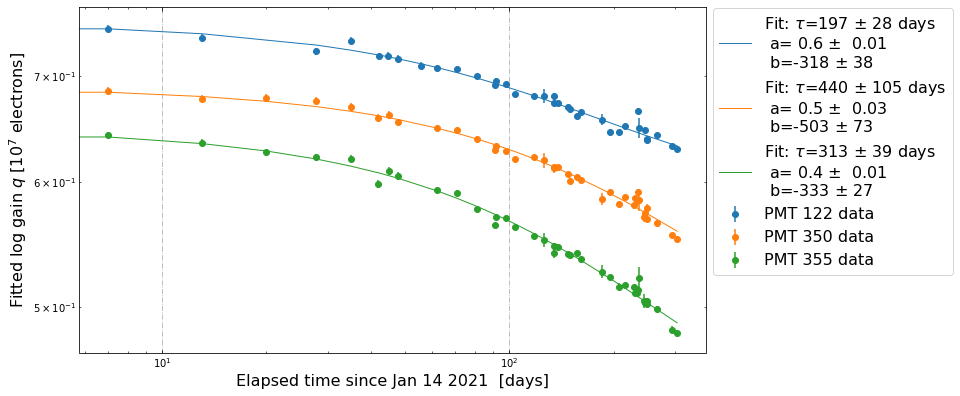

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10, 5.6))
tmin = np.min(data.index)

for PMT in [122, 350, 355] :        
                     
        # Fit a decay
        time, gain, error, params, perrors = pmt_gain_timeserie_decay( df=data, pmt=PMT, targets=[ "q", "eq"] )
        out = ax.errorbar( x=time, y=gain, yerr=error, fmt='o', label="PMT %d data" % PMT)
        
        if params[0]==-99:
            print("Failed fit for PMT {}".format(PMT))
        else:
            ax.plot( time, [ decay( t, *params ) for t in time ], color=out[0].get_color(), lw=1 , label="Fit: $\\tau$=%.0f $\pm$ %.0f days \n a= %.1f $\pm$ % .2f \n b=%d $\pm$ %d" % ( params[2], perrors[2], params[0], perrors[0], params[1], perrors[1] ) )
        
ax.set_xscale("Log")
ax.set_yscale("Log")
ax.set_ylabel("Fitted log gain $q$ [$10^7$ electrons]", fontsize=16)
ax.set_xlabel( "Elapsed time since %s  [days]" % datetime.fromtimestamp(tmin).strftime("%b %d %Y"), fontsize=16  )
       
fig.legend(fontsize=16, bbox_to_anchor=[1.34, 0.99])
plt.tight_layout()
        
        
print("ALL DONE")

In [10]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("decays_gain_fit_timeseries.pdf")

for PMT in range(0, 359) :        
        
        fig, ax = plt.subplots(1,1, figsize=(9, 5.3))
        tmin = np.min(data.index)
             
        # Fit a decay
        time, gain, error, params, perrors = pmt_gain_timeserie_decay( df=data, pmt=PMT, targets=[ "q", "eq"] )
        out = ax.errorbar( x=time, y=gain, yerr=error, fmt='o', label="PMT %d data" % PMT)
        
        if params[0]==-99:
            print("Failed fit for PMT {}".format(PMT))
        else:
            ax.plot( time, [ decay( t, *params ) for t in time ], color=out[0].get_color(), lw=1 , label="Fit: $\\tau$=%.0f $\pm$ %.0f days" % ( params[2], perrors[2] ) )
        
        ax.set_ylabel("Fitted gain $q$ [$10^7$ electrons]", fontsize=16)
        ax.set_xlabel( "Elapsed time since %s  [days]" % datetime.fromtimestamp(tmin).strftime("%b %d %Y"), fontsize=16  )
    
            #ax.set_ylim((0.46, 0.86))        
        plt.legend()
        plt.tight_layout()
        
        pdf.savefig( fig )
        
        plt.close(fig)

pdf.close()
        
print("ALL DONE")

/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpac

Failed fit for PMT 51


/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpac

Failed fit for PMT 85


/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Failed fit for PMT 117


/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpac

Failed fit for PMT 241
Failed fit for PMT 247
Failed fit for PMT 255
Failed fit for PMT 263
Failed fit for PMT 264
Failed fit for PMT 269
Failed fit for PMT 275


/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Failed fit for PMT 286
Failed fit for PMT 293
Failed fit for PMT 300
Failed fit for PMT 307
Failed fit for PMT 309


/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Failed fit for PMT 348
Failed fit for PMT 352
Failed fit for PMT 357
ALL DONE


In [89]:
fit_results_gain = []
fit_results_mu = []

for pmt in range(0, 360):

    if pmt in [ 70, 106, 217]: 
        continue
        
    _,_,_, params, perrors = pmt_gain_timeserie( df=data, pmt=pmt, targets=[ "q", "eq"] )
    fit_results_gain.append( [pmt, params[0], perrors[0], params[1], perrors[1]] ) 

    _,_,_, params, perrors = pmt_gain_timeserie( df=data, pmt=pmt, targets=[ "mu", "emu"] )
    fit_results_mu.append( [pmt, params[0], perrors[0], params[1], perrors[1]] ) 
    
fit_results_gain = np.array( fit_results_gain )
fit_results_mu = np.array( fit_results_mu )

dffit = pd.DataFrame( { "pmt_id":360-fit_results_gain[:,0], 
                        "gain_const":fit_results_gain[:,1], 
                        "e_gain_const":fit_results_gain[:,2], 
                        "gain_slope" : fit_results_gain[:,3], 
                        "e_gain_slope" : fit_results_gain[:,4], 
                        "mu_const": fit_results_mu[:,1],
                        "e_mu_const": fit_results_mu[:,2], 
                        "mu_slope": fit_results_mu[:,3],
                        "e_mu_slope": fit_results_mu[:,4]} )

dffit["gain_var"] = 100*dffit["gain_slope"]/dffit["gain_const"]
dffit["mu_var"] = 100*dffit["mu_slope"]/dffit["mu_const"]

#dffit=dffit.set_index("pmt")

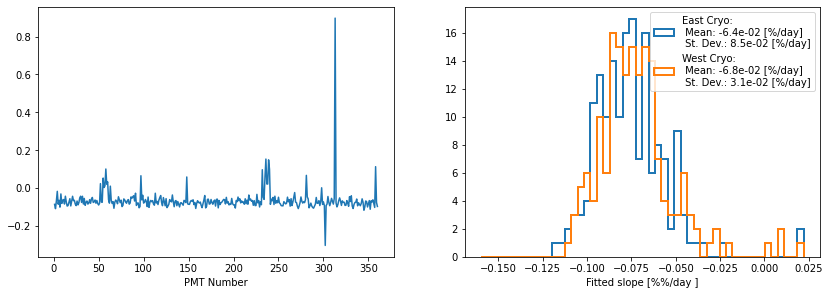

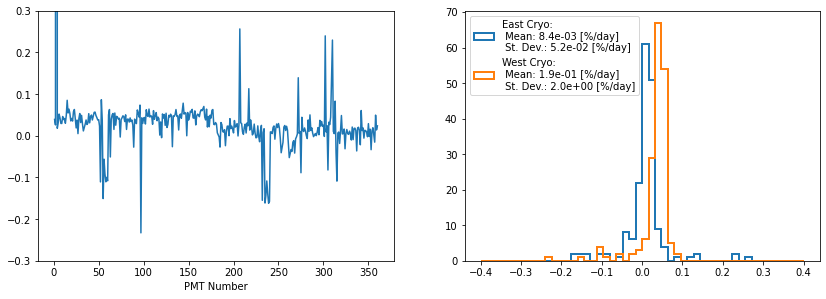

In [90]:
ax = overviewFitPlot( dffit, "gain_var", setrange=(-0.16, 0.022), setbins=50 )
ax[1].set_xlabel( "Fitted slope [%%/day ]")

plt.savefig( "gain_var.png" )

ax = overviewFitPlot( dffit, "mu_var", setrange=(-0.4, 0.4), setbins=50 )

ax[1].legend(loc='upper left')
ax[0].set_ylim( (-0.3, 0.3) )

plt.savefig( "mu_var.png" )

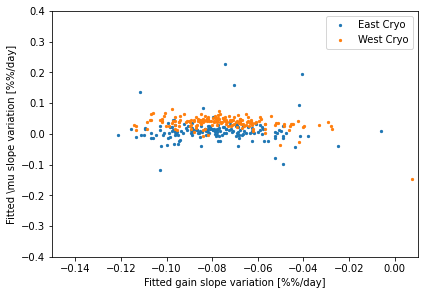

In [51]:



fig, ax = plt.subplots(1,1, figsize=(6,4.2))

SEL_E=dffit.pmt_id>=180 ; SEL_W=dffit.pmt_id<180
ax.scatter( dffit[SEL_E].gain_var, dffit[SEL_E].mu_var, s=5, label="East Cryo" )
ax.scatter( dffit[SEL_W].gain_var, dffit[SEL_W].mu_var, s=5, label="West Cryo" )

ax.legend()
ax.set_ylabel( "Fitted \mu slope variation [%%/day]" )
ax.set_xlabel( "Fitted gain slope variation [%%/day]" )

ax.set_ylim( (-0.4, 0.4) )
ax.set_xlim( (-0.15, 0.01) )

fig.tight_layout()
fig.savefig("correlation_gain_mu.png")
plt.show()

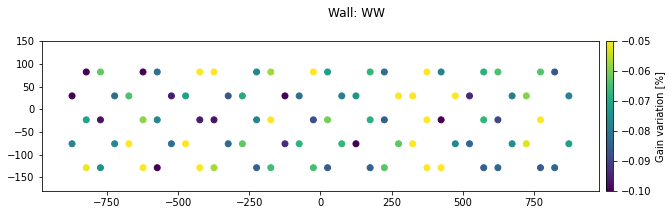

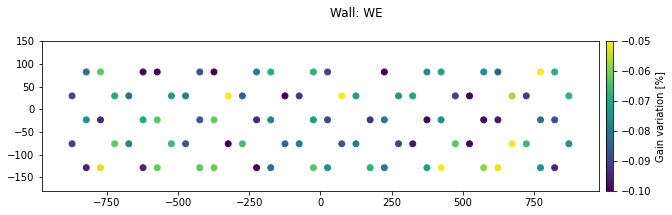

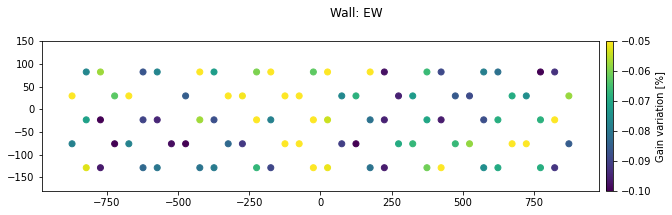

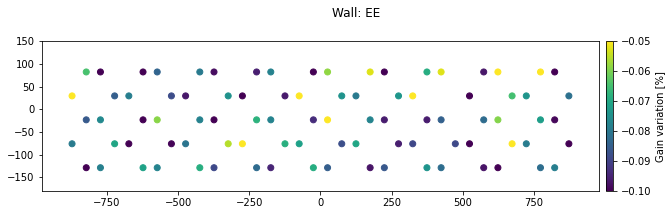

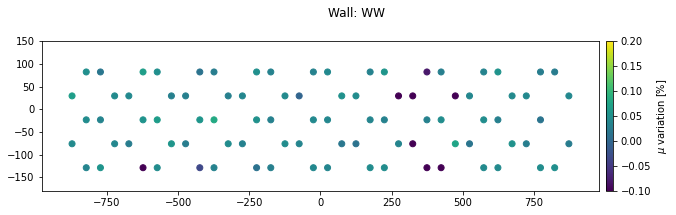

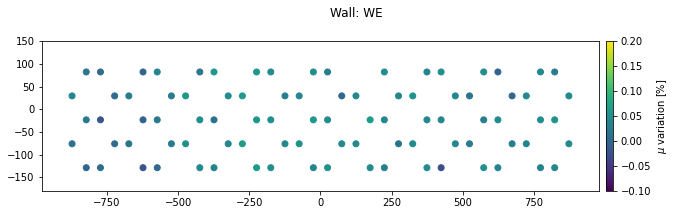

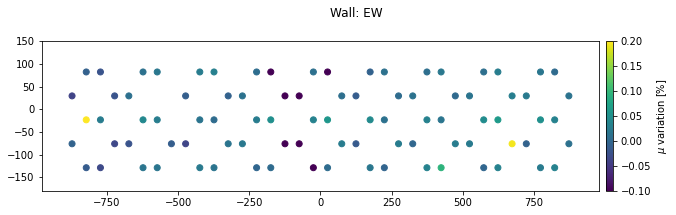

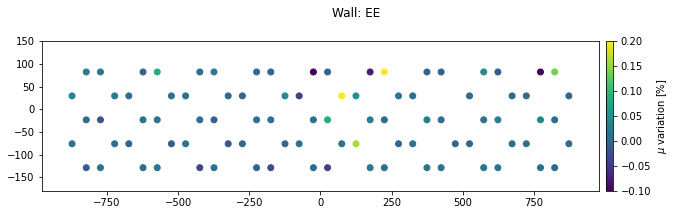

In [52]:
# Here we try to verify any correlation between the fitted slope ( gain variation ) 

# We need to manipulate the pmt value a little bit: the pmt number currently reported is the old channel_id. 
# we need to go to the new channel_id using the pmt_id. in the old file 360-channel_id = pmt_id. This doesn't change in the new file. 
# We then use the new channel_id to link the pmt with the correct xyz position

pos = pd.read_csv("geofile.csv")
x=pos.x.values; y=pos.y.values; z=pos.z.values

geo["x"] = geo.channel_id.apply( lambda i : x[i] )
geo["y"] = geo.channel_id.apply( lambda i : y[i] )
geo["z"] = geo.channel_id.apply( lambda i : z[i] )

dffit.set_index("pmt_id", inplace=True)
dffit=dffit.join( geo, on="pmt_id" )

# Here is gain
for i, side in enumerate(["WW", "WE", "EW", "EE"]):
    
    SEL_SIDE=dffit.pmt_in_tpc_plane == side
    seldb = dffit[SEL_SIDE]
    
    fig, ax = plt.subplots( 1,1, figsize=(10,3) )

    fig.suptitle("Wall: %s" % side)
    
    out = ax.scatter( x=seldb.z, y=seldb.y, c=seldb.gain_var, vmin=-0.1, vmax=-0.05 )
    fig.colorbar( out, ax=ax, pad=0.01, label="Gain variation [%]")
    
    ax.set_ylim((-180, 150))
    ax.set_xlim((-980, 980))

    fig.tight_layout()
    fig.savefig( "wall_%s_gain_vairation.png" % side )
    

# here is mu
for i, side in enumerate(["WW", "WE", "EW", "EE"]):
    
    SEL_SIDE=dffit.pmt_in_tpc_plane == side
    seldb = dffit[SEL_SIDE]
    
    fig, ax = plt.subplots( 1,1, figsize=(10,3) )

    fig.suptitle("Wall: %s" % side)
    
    out = ax.scatter( x=seldb.z, y=seldb.y, c=seldb.mu_var, vmin=-0.1, vmax=0.2 )
    fig.colorbar( out, ax=ax, pad=0.01, label="$\mu$ variation [%]")
    
    ax.set_ylim((-180, 150))
    ax.set_xlim((-980, 980))

    fig.tight_layout()
    fig.savefig( "wall_%s_mu_vairation.png" % side )

#### 

In [84]:
def getDAQId( frag, dig ):
    return frag*15+dig

geo['daq_id'] = geo.apply(lambda x : getDAQId( x.fragment_id, x.digitizer_ch_number ), axis=1)

print(geo[geo.daq_id==8].channel_id)


43    350
Name: channel_id, dtype: int64


In [12]:
import matplotlib
matplotlib.matplotlib_fname()

'/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'